In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
import pandas as pd
from utils.store_data import ReadData
import numpy as np
import torch
from utils.arguments import Arguments
from tqdm import tqdm
from sklearn.decomposition import PCA
from linear_probe import get_linear_acc
import random
import os
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve
from ml_utils.semantic_entropy import best_split,binarize_entropy
#from answer_judge.bleurt import BleurtJudge
from answer_judge.vqaEval import VQAEval
from ml_utils.semantic_clustering.semantic_clustering import SemanticClustering
from ml_utils.semantic_clustering.semantic_entropy import EntailmentDeberta,EntailmentLlama

In [2]:
data_reader=ReadData('/root/autodl-tmp/hallscope/pope/popular/multi/train')
data=data_reader.read_all()
random.shuffle(data)

In [3]:
df=pd.DataFrame(data)

In [4]:
df.head()

,img_path,question,label,question_id,category,most_likely,responses
0,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a car in the image?\nAnswer the ques...,"[tensor(1), tensor(0)]","[tensor(2005), tensor(2006)]","[popular, popular]",{'embedding': [[[ 0.00389099 0.00149536 0.00...,"[Yes, Yes, Yes, Yes, Yes, Yes, No, No, No, No,..."
1,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a chair in the image?\nAnswer the qu...,"[tensor(1), tensor(0)]","[tensor(4089), tensor(4090)]","[popular, popular]",{'embedding': [[[ 0.00389099 0.00149536 0.00...,"[No, No, No, No, Yes, No, No, No, No, Yes, Yes..."
2,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a dining table in the image?\nAnswer...,"[tensor(1), tensor(0)]","[tensor(3335), tensor(3336)]","[popular, popular]",{'embedding': [[[ 0.00389099 0.00149536 0.00...,"[Yes, Yes, Yes, Yes, No, Yes, No, No, No, No, ..."
3,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a cat in the image?\nAnswer the ques...,"[tensor(1), tensor(0)]","[tensor(797), tensor(798)]","[popular, popular]",{'embedding': [[[ 0.00389099 0.00149536 0.00...,"[Yes, Yes, Yes, Yes, No, Yes, No, No, No, No, ..."
4,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a car in the image?\nAnswer the ques...,"[tensor(1), tensor(0)]","[tensor(4531), tensor(4532)]","[popular, popular]",{'embedding': [[[ 0.00389099 0.00149536 0.00...,"[No, No, No, No, No, No, No, No, No, No, No, No]"


In [5]:
df.shape

(2500, 7)

In [6]:
i=1

In [ ]:
df.iloc[i]['img_path']

['/root/autodl-fs/coco_images/train/COCO_train2014_000000129359.jpg',
 '/root/autodl-fs/coco_images/train/COCO_train2014_000000129359.jpg']

In [8]:
df.iloc[i]['most_likely']['response']

['No', 'No']

In [9]:
df.iloc[i]['question']

['Is there a chair in the image?\nAnswer the question using a single word or phrase.',
 'Is there a bottle in the image?\nAnswer the question using a single word or phrase.']

In [ ]:
df.iloc[i]['responses']

['No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes']

In [11]:
embeddings=df['most_likely'].apply(lambda x: x['embedding']).to_list()

In [12]:
embeddings=np.concatenate(embeddings,axis=0)

In [13]:
embeddings.shape

(5000, 33, 4096)

In [14]:
gt_label=df['label'].to_list()
gt_label=np.concatenate(gt_label,axis=0).tolist()

In [15]:
responses=df['most_likely'].apply(lambda x: x['response']).to_list()
resps=[]
for sublist in responses:
    resps+=sublist

In [16]:
resps[0:5]

['Yes', 'No', 'No', 'No', 'Yes']

In [17]:
is_correct=[]
for i,x in enumerate(resps):
    if x.lower()=='no' and gt_label[i]==0:
        is_correct.append(1)
    elif x.lower()=='yes' and gt_label[i]==1:
        is_correct.append(1)
    else:
        is_correct.append(0)
is_correct=np.array(is_correct)

In [18]:
is_correct.shape

(5000,)

In [19]:
print(f'There are {len(is_correct)} responses. {sum(is_correct==1)} answer correctly and {sum(is_correct==0)} answer wrongly')

There are 5000 responses. 4325 answer correctly and 675 answer wrongly


In [20]:
def split_multi_responses(x,n_multi_gen=6):
    return [x[i:i + n_multi_gen] for i in range(0, len(x), n_multi_gen)]

all_responses=df['responses'].apply(split_multi_responses).to_list()
all_responses_flatten=[]
for sublist in all_responses:
    for item in sublist:
        all_responses_flatten.append([x.lower() for x in item])
all_responses=all_responses_flatten
all_responses

[['yes', 'yes', 'yes', 'yes', 'yes', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['no', 'no', 'no', 'no', 'yes', 'no'],
 ['no', 'no', 'no', 'yes', 'yes', 'yes'],
 ['yes', 'yes', 'yes', 'yes', 'no', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['yes', 'yes', 'yes', 'yes', 'no', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['yes', 'yes', 'yes', 'yes', 'yes', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['yes', 'no', 'no', 'yes', 'no', 'no'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['no', 'yes', 'yes', 'no', 'no', 'no'],
 ['no', 'no', 'yes', 'no', 'no', 'no'],
 ['yes', 'yes', 'yes', 'yes', 'yes', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['yes', 'yes', 'yes', 'yes', 'yes', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['yes', 'no', 'yes', 'no', 'yes', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['yes', 'yes', 'yes', 'yes', 'yes', 'yes'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['yes', 'n

In [21]:
entailment_model=EntailmentLlama('/root/autodl-fs/llava-1.5-7b-hf')
cluster=SemanticClustering(entailment_model)
entropies=[]

for i in tqdm(range(len(all_responses))):
    e=cluster.get_entropy(all_responses[i])
    entropies.append(e)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transformers v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
  0%|          | 0/5000 [00:11<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'shape'

In [39]:
np.save('./entropies_pope',entropies)

In [40]:
entropies=np.load('./entropies_pope.npy',allow_pickle=True)

In [41]:
length=len(is_correct)
train_rate=0.8

all_indices = np.random.permutation(length)
train_idxs = all_indices[:int(
    train_rate * length)]  # trainset and validation index

test_idxs=all_indices[int(
    train_rate * length):]  #test index


'''get testset, wildset and valset. The valset is used for determining the hype-parameters'''
hall_label_test = is_correct[test_idxs]
hall_label_train = is_correct[train_idxs]

print(f'trainset length:{len(hall_label_train)}')
print(f'testset length:{len(hall_label_test)}')
print(f'trainset postive: {sum(hall_label_train==1)} negative: {sum(hall_label_train==0)}')
print(
    f'testset postive: {sum(hall_label_test==1)} negative: {sum(hall_label_test==0)}')

trainset length:4000
testset length:1000
trainset postive: 3473 negative: 527
testset postive: 852 negative: 148


In [42]:
all_embeddings = embeddings
all_embeddings.shape

(5000, 33, 4096)

In [43]:
embedding_train = all_embeddings[train_idxs]
embedding_test = all_embeddings[test_idxs]

In [44]:
%load_ext autoreload
%autoreload 2
from ml_utils.grid_search import GridSearch
from ml_utils.PCA_discriminator import PCADiscriminator
from ml_utils.metrics import auroc,get_best_split_from_scores

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Binarize Entropy

/root/miniconda3/envs/dl3.9/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/dl3.9/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'y_train' is not defined

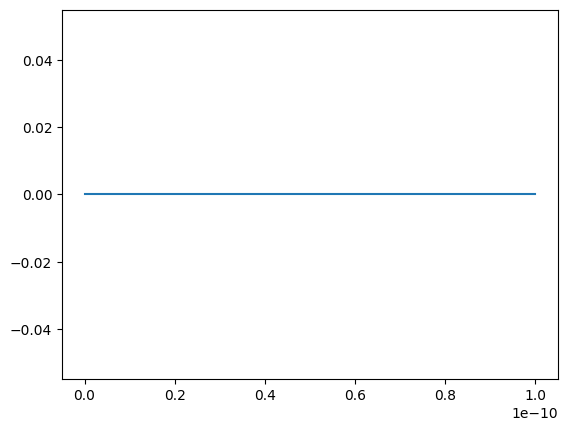

In [48]:
entropy_split=best_split(entropies, "All datasets collective")
y_train=binarize_entropy(y_train, entropy_split)

Grid Search for Best 'n_components' & 'layer'

In [ ]:
best_layer=25

In [62]:
X_train=embedding_train[:, best_layer,:]
y_train=y_train

X_test=embedding_test[:, best_layer,:]
y_test=hall_label_test

In [ ]:
model = LogisticRegression()

model.fit(X_train,y_train)

In [ ]:
y_test_pred=model.predict(X_test)
accuracy = accuracy_score(1-y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")